In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import KFold
from google.colab import drive
drive.mount('/content/drive')
import os
# List files in your Google Drive
!ls /content/drive/MyDrive/UCSD_Courses/Data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
df_daily_technical_indicators.feather


In [2]:
!pip install torch --upgrade

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [4]:
df = pd.read_feather("/content/drive/MyDrive/UCSD_Courses/Data/df_daily_technical_indicators.feather")

In [28]:
# generate a label if stock return > median. label = 1; else label = 0
# when calculating median, eliminate meanless data points from padding value
median_return = df[df['Future 30 days return'] != 0].groupby('date')['Future 30 days return'].median()
df['median_return'] = df.index.get_level_values('date').map(median_return)
df['label'] = (df['Future 30 days return'] > df['median_return']).astype(int)

In [29]:
# Convert DataFrame to numeric, forcing non-numeric values to NaNs
df = df.apply(pd.to_numeric, errors='coerce')
df = df.replace([np.inf, -np.inf], np.nan).fillna(0)

In [30]:
# Calculate the cumulative data the stock data got!
df['data_cumcount'] = df.groupby('PERMNO').cumcount()

In [86]:
# define the look_back_period as the time series length the model trained on
look_back_period = 100
begin_date = '2000-01-01'
end_date = '2001-12-31'
train_test_split_date = '2001-01-01'
date = df.index.get_level_values('date')
df_temp = df[(date>begin_date)&(date<=end_date)].copy()
del date
# We only want data point with enough lag information
df_temp = df_temp[df_temp['data_cumcount'] > look_back_period]
# eliminate meanless data points from padding value
df_temp = df_temp[df_temp['Future 30 days return'] != 0]
df_temp = df_temp.reset_index()

# Generate Pair_PERMNO_date for future indexing
df_temp['Pair_PERMNO_date'] = list(zip(df_temp['PERMNO'], df_temp['date']))
# take the last day in the month as sample
df_temp['date'] = pd.to_datetime(df_temp['date']).dt.to_period('M').astype(str)
df_temp = df_temp.groupby(['PERMNO','date']).tail(1)

# reset index to make it more convenient for future use
df_temp = df_temp.reset_index()

In [87]:
df_temp

,index,PERMNO,date,Bollinger Band Percent,rsi,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,Momentum,OBV,ATR,Future 30 days return,Size,lag vwretx,lag ewretx,lag sprtrn,median_return,label,data_cumcount,Pair_PERMNO_date
0,16,10001,2000-01,0.580792,51.120384,-0.010928,0.000248,-0.011176,-0.011070,-0.019013,2.816686,-0.067164,1,-0.028136,-0.015087,-0.027457,0.004068,0,2684,"(10001, 2000-01-31)"
1,30,10001,2000-02,0.532245,49.355665,-0.004707,0.001146,-0.005853,0.000000,-0.057178,3.666503,-0.007634,1,0.007648,0.006051,0.011017,-0.021127,1,2699,"(10001, 2000-02-29)"
2,44,10001,2000-03,0.387291,46.403672,-0.006959,0.000922,-0.007880,0.008000,0.252350,-1.736535,0.031746,1,-0.010854,-0.013530,0.000524,-0.084507,1,2716,"(10001, 2000-03-30)"
3,58,10001,2000-04,0.951606,55.424782,0.003787,0.002927,0.000860,0.015385,-0.014446,6.956522,-0.083333,1,0.007071,0.004361,0.002690,0.014306,0,2732,"(10001, 2000-04-28)"
4,67,10001,2000-05,0.341433,48.157011,-0.001708,-0.000805,-0.000903,0.000000,-0.352794,-10.815603,-0.039062,2,-0.011642,-0.005231,-0.012530,0.058824,0,2742,"(10001, 2000-05-26)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79586,1474147,93105,2001-10,0.072315,43.760258,-0.005722,-0.004200,-0.001523,-0.062923,-0.015014,-6.740016,0.149458,4,-0.017214,-0.011514,-0.017166,0.067972,1,2667,"(93105, 2001-10-31)"
79587,1474168,93105,2001-11,0.998371,63.588640,0.021093,0.008327,0.012766,0.152017,-0.023222,5.986582,-0.010632,4,0.011143,0.009134,0.010350,0.034185,0,2688,"(93105, 2001-11-30)"
79588,1474186,93105,2001-12,0.679373,58.469415,0.015855,-0.002994,0.018849,0.011920,0.077209,4.098949,-0.011159,3,0.004338,0.009255,0.003362,-0.015302,1,2708,"(93105, 2001-12-31)"
79589,1474205,93316,2000-01,0.702860,63.094786,0.085428,-0.007316,0.092744,0.159420,0.073772,1.843464,0.016667,1,-0.003599,-0.002345,-0.003938,-0.004476,1,1326,"(93316, 2000-01-28)"


In [88]:
df_train = df_temp[df_temp['date']<train_test_split_date]
df_test = df_temp[df_temp['date']>=train_test_split_date]

In [89]:
label_name = 'label'
X_train = df_train.drop(label_name, axis=1)
X_test = df_test.drop(label_name, axis=1)

y_train = df_train[label_name]
y_test = df_test[label_name]

In [90]:
class TimeSeriesDataset(Dataset):
    def __init__(self, whole_data, X, y=None, augment=True):
        self.whole_data = whole_data
        self.X = X #torch.tensor(X, dtype=torch.float32)
        self.y = y if y is not None else None #torch.tensor(y, dtype=torch.float32) if y is not None else None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):


        if self.y is not None:
          x = []
          y = []

          permo_date_locator = df.index.get_loc(df_temp['Pair_PERMNO_date'][idx])
          #get x given index
          x_temp  = df.iloc[permo_date_locator-look_back_period+1:permo_date_locator+1].drop(['Future 30 days return', 'median_return', 'label', 'data_cumcount'], axis = 1).to_numpy()
          x.append(x_temp)
          #get y given index
          y_temp = df.iloc[permo_date_locator]['label']
          y.append(y_temp)

          x = torch.tensor(x_temp, dtype=torch.float32)
          y = torch.tensor(y_temp, dtype=torch.float32)
          return x, y

        else:
          x = []
          i = idx
          permo_date_locator = df.index.get_loc(df_temp['Pair_PERMNO_date'][idx])
          #get x given index
          x_temp  = df.iloc[permo_date_locator-look_back_period+1:permo_date_locator+1].drop(['Future 30 days return', 'median_return', 'label', 'data_cumcount'], axis = 1).to_numpy()
          x.append(x_temp)

          x = torch.tensor(x_temp, dtype=torch.float32)

          return x

        '''
    def get_time_series_sample(self, x):
        return x
        '''

In [91]:
df

Bollinger Band Percent        rsi  MACD_12_26_9  \
PERMNO date                                                          
10001  1986-02-26                0.895285  69.377403      0.009111   
       1986-02-27                0.851887  69.377403      0.009368   
       1986-02-28                0.979186  73.918841      0.010152   
       1986-03-03                0.590435  56.023616      0.009341   
       1986-03-04                0.573235  56.023616      0.008440   
...                                   ...        ...           ...   
93436  2023-11-09                0.492374  46.000779     -0.036636   
       2023-11-10                0.346916  38.538966     -0.039103   
       2023-11-13                0.438164  42.411998     -0.036350   
       2023-11-14                0.631862  49.111857     -0.029819   
       2023-11-15                0.998316  57.217313     -0.019441   

                   MACDh_12_26_9  MACDs_12_26_9  Momentum       OBV  \
PERMNO date                                                           
10001  1986-02-26       0.000926       0.008185  0.030612 -0.017736   
       1986-02-27       0.000946       0.008421  0.030612 -0.025592   
       1986-02-28       0.001450       0.008701  0.030303  0.768732   
       1986-03-03       0.000372       0.008968 -0.009901 -0.380366   
       1986-03-04      -0.000423       0.008863  0.000000  0.016461   
...                          ...            ...       ...       ...   
93436  2023-11-09       0.008824      -0.045460  0.047293  0.002503   
       2023-11-10       0.007186      -0.046290 -0.030205 -0.048671   
       2023-11-13       0.007146      -0.043496  0.010498  0.014638   
       2023-11-14       0.009532      -0.039351  0.087238  0.009032   
       2023-11-15       0.014112      -0.033553  0.145248 -0.014639   

                         ATR  Future 30 days return  Size  lag vwretx  \
PERMNO date                                                             
10001  1986-02-26  16.428309               0.000000     2   -0.001791   
       1986-02-27  15.141755               0.000000     2    0.001307   
       1986-02-28  25.018615              -0.009804     3    0.010952   
       1986-03-03  -3.246377               0.010000     2    0.001845   
       1986-03-04  -4.666667               0.010000     1   -0.003870   
...                      ...                    ...   ...         ...   
93436  2023-11-09   0.405085               0.145829    10   -0.000455   
       2023-11-10  -0.002893               0.202686    10   -0.008586   
       2023-11-13  -0.036597               0.195481    10    0.013823   
       2023-11-14   0.342494               0.168656    10   -0.000386   
       2023-11-15   0.749947               0.066425    10    0.022639   

                   lag ewretx  lag sprtrn  median_return  label  data_cumcount  
PERMNO date                                                                     
10001  1986-02-26    0.000788   -0.002452       0.042313      0              0  
       1986-02-27    0.003222    0.001117       0.046225      0              1  
       1986-02-28    0.007195    0.012185       0.035714      0              2  
       1986-03-03    0.005390    0.000661       0.037037      0              3  
       1986-03-04    0.000720   -0.006610       0.037736      0              4  
...                       ...         ...            ...    ...            ...  
93436  2023-11-09   -0.006451    0.001005       0.139057      1           2693  
       2023-11-10   -0.014880   -0.008084       0.158942      1           2694  
       2023-11-13    0.004011    0.015616       0.155249      1           2695  
       2023-11-14    0.000257   -0.000836       0.155214      1           2696  
       2023-11-15    0.030881    0.019075       0.106725      0           2697  

[32477610 rows x 16 columns]

In [92]:
# Create dataset
dataset = TimeSeriesDataset(df, X_train, y_train)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [93]:
len(next(iter(dataloader)))

2

# Building my NN Model

In [94]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 42

In [106]:
# Define a simpler Model
class SimpleConvEncoder(nn.Module):
    def __init__(self, T, C):
        super(SimpleConvEncoder, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=C, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change shape to [B, C, T]
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        return x

# Define a simple Classification Head
class SimpleClassificationHead(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SimpleClassificationHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 4)
        self.fc3 = nn.Linear(hidden_dim // 4, 1)  # Output 1 node for binary classification
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Combine Encoder and Classification Head into one model
class SimpleTimeSeriesModel(nn.Module):
    def __init__(self, T, C, hidden_dim):
        super(SimpleTimeSeriesModel, self).__init__()
        self.encoder = SimpleConvEncoder(T, C)
        self.classification_head = SimpleClassificationHead(T * 256, hidden_dim)  # Update input dim based on the flattened size
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, x, ybatch=None):
        x = self.encoder(x)  # x shape will be [B, T * 256] after flattening
        logits = self.classification_head(x).squeeze(-1)  # logits shape will be [B]
        loss = None
        if ybatch is not None:
            loss = self.loss_fn(logits, ybatch.float())

        return logits, loss


In [111]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0, fold=None):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.fold = fold

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'Validation loss did not improve for {self.counter} epochs')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), f'checkpoint_fold_{self.fold}.pth')
        self.val_loss_min = val_loss

Fold 1
Epoch [1/2000], Fold 1, Train Loss: 0.9778, Val Loss: 0.6927
Validation loss decreased (inf --> 0.692744). Saving model...
Epoch [2/2000], Fold 1, Train Loss: 0.6932, Val Loss: 0.6928
Validation loss did not improve for 1 epochs
Epoch [3/2000], Fold 1, Train Loss: 0.6930, Val Loss: 0.6928
Validation loss did not improve for 2 epochs
Epoch [4/2000], Fold 1, Train Loss: 0.6935, Val Loss: 0.6928
Validation loss did not improve for 3 epochs
Epoch [5/2000], Fold 1, Train Loss: 0.6933, Val Loss: 0.6928
Validation loss did not improve for 4 epochs
Epoch [6/2000], Fold 1, Train Loss: 0.6929, Val Loss: 0.6926
Validation loss decreased (0.692744 --> 0.692592). Saving model...
Epoch [7/2000], Fold 1, Train Loss: 0.6926, Val Loss: 0.6918
Validation loss decreased (0.692592 --> 0.691811). Saving model...
Epoch [8/2000], Fold 1, Train Loss: 0.6922, Val Loss: 0.6927
Validation loss did not improve for 1 epochs
Epoch [9/2000], Fold 1, Train Loss: 0.6927, Val Loss: 0.6900
Validation loss decreas

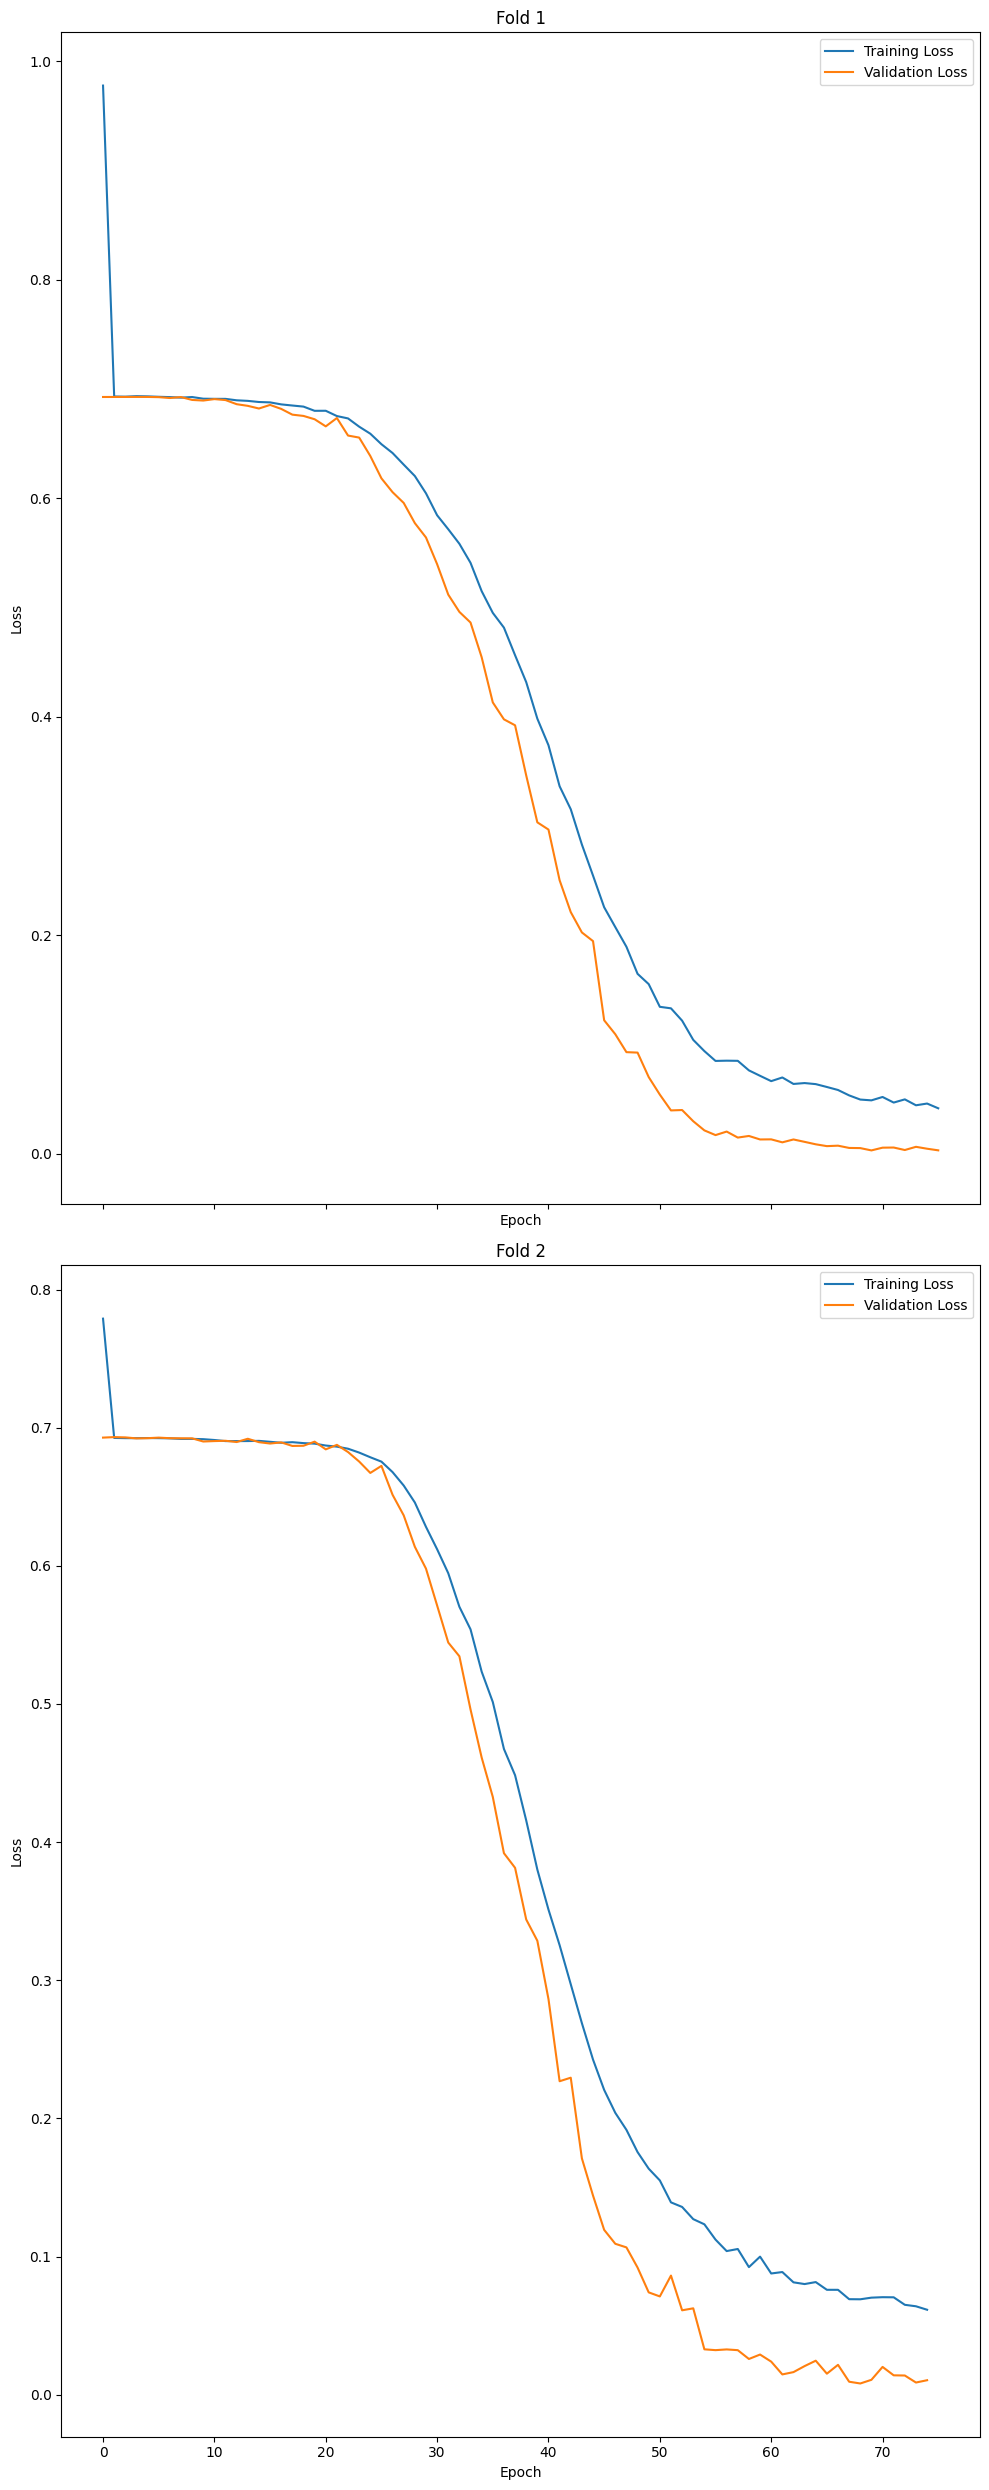

In [115]:
label_name = 'Future 30 days return'
X = df_train.drop(label_name, axis=1)
X_test = df_test.drop(label_name, axis=1)

y = df_train[label_name]
y_test = df_test[label_name]


# Parameters
T = look_back_period
C = df_temp.shape[1]-8
n_embd = T*C
max_seq_length = n_embd
n_layer = 2 # 6
n_head = 4 # 4
n_hidden = 1000 # 1000


batch_size = 128

# Cross-validation parameters
n_splits = 2

epochs = 2000#1000
patience = 6
seed = 42
learning_rate = 0.001#
clip_value = 5.0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# This a not a commmon use, but what it achieve is that is make sure training/vadilation dataset will seize non-overlapping data
tscv = TimeSeriesSplit(n_splits=n_splits)
train_losses_per_fold = []
val_losses_per_fold = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    print(f'Fold {fold+1}')
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    train_dataset = TimeSeriesDataset(df, X_train, y_train)
    val_dataset = TimeSeriesDataset(df, X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    #model = EncoderRegression(n_embd=n_embd, n_layer=n_layer, n_head=n_head, n_hidden=n_hidden, device=device, seed=seed, max_seq_length=max_seq_length, T=T, C=C).to(device)
    model = SimpleTimeSeriesModel(T, C, n_hidden).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)#lr = 0.00001
    #criterion = nn.CrossEntropyLoss()

    early_stopping = EarlyStopping(patience=patience, verbose=True, fold=fold+1)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):  # Number of epochs
        model.train()
        running_train_loss = 0.0
        for batch_idx, (xbatch, ybatch) in enumerate(train_loader):


            # common training procesure
            xbatch, ybatch = xbatch.to(device), ybatch.to(device)

            assert not torch.isnan(xbatch).any(), "Input contains NaNs"
            assert not torch.isnan(ybatch).any(), "Labels contain NaNs"
            optimizer.zero_grad()
            out, loss = model(xbatch, ybatch)

            if torch.isnan(out).any():
                print("Batch:", batch_idx)
                print("Inputs:", xbatch)
                print("Outputs:", out)
                raise ValueError("NaN detected in outputs")
            if torch.isnan(loss):
              print("Batch:", batch_idx)
              print("Inputs:", xbatch)
              print("Outputs:", out)
              print("Loss:", loss)
              raise ValueError("NaN loss detected")


            loss.backward()

            # Call the gradient clipping function
            #clip_and_monitor_gradients(model, clip_value)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_value)


            optimizer.step()
            running_train_loss += loss.item()
            #if batch_idx % 30 == 0:
            # print(f'Batch {(batch_idx+1)/len(train_loader)*100}%; batch loss: {loss.item()}')

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for xbatch, ybatch in val_loader:

                xbatch, ybatch = xbatch.to(device), ybatch.to(device)
                out, loss = model(xbatch, ybatch)
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        #if epoch % 5 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Fold {fold+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        # Check early stopping
        early_stopping(avg_val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    train_losses_per_fold.append(train_losses)
    val_losses_per_fold.append(val_losses)

    # Load the last checkpoint with the best model for this fold
    model.load_state_dict(torch.load(f'checkpoint_fold_{fold+1}.pth'))

# Plotting learning curves for each fold
fig, axes = plt.subplots(n_splits, 1, figsize=(10, 25), sharex=True)

for fold in range(n_splits):
    axes[fold].plot(train_losses_per_fold[fold], label='Training Loss')
    axes[fold].plot(val_losses_per_fold[fold], label='Validation Loss')
    axes[fold].set_title(f'Fold {fold+1}')
    axes[fold].set_xlabel('Epoch')
    axes[fold].set_ylabel('Loss')
    axes[fold].legend()

plt.tight_layout()
plt.show()

In [122]:
# Early stopping mechanism
class EarlyStopping_Train:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.train_loss_min = np.Inf
        self.delta = delta

    def __call__(self, train_loss, model):
        score = -train_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(train_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'Training loss did not improve for {self.counter} epochs')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(train_loss, model)
            self.counter = 0

    def save_checkpoint(self, train_loss, model):
        if self.verbose:
            print(f'Training loss decreased ({self.train_loss_min:.6f} --> {train_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), 'checkpoint.pth')
        self.train_loss_min = train_loss

In [123]:
# Train the model on the entire training data
train_dataset = TimeSeriesDataset(df, X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

model = SimpleTimeSeriesModel(T, C, n_hidden).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

epochs = 1000  # Change this value as needed
early_stopping = EarlyStopping_Train(patience=10, verbose=True)

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    for batch_idx, (xbatch, ybatch) in enumerate(train_loader):
        xbatch, ybatch = xbatch.to(device), ybatch.to(device)
        optimizer.zero_grad()
        out, loss = model(xbatch, ybatch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_value)
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}')

    # Early stopping
    early_stopping(avg_train_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break



Epoch [1/1000], Train Loss: 0.8268
Training loss decreased (inf --> 0.826750). Saving model...
Training loss decreased (0.826750 --> 0.692758). Saving model...
Training loss decreased (0.692758 --> 0.692426). Saving model...
Training loss decreased (0.692426 --> 0.692414). Saving model...
Training loss decreased (0.692414 --> 0.692345). Saving model...
Training loss did not improve for 1 epochs
Training loss did not improve for 2 epochs
Training loss did not improve for 3 epochs
Training loss decreased (0.692345 --> 0.692340). Saving model...
Training loss decreased (0.692340 --> 0.691855). Saving model...
Epoch [11/1000], Train Loss: 0.6922
Training loss did not improve for 1 epochs
Training loss did not improve for 2 epochs
Training loss decreased (0.691855 --> 0.691243). Saving model...
Training loss decreased (0.691243 --> 0.690621). Saving model...
Training loss did not improve for 1 epochs
Training loss did not improve for 2 epochs
Training loss decreased (0.690621 --> 0.689166).

NameError: name 'confusion_matrix' is not defined

In [148]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, ConfusionMatrixDisplay


# Load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pth'))
# Predict on the test data
test_dataset = TimeSeriesDataset(df, X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Evaluate the model
model.eval()
all_preds = []
all_labels = []
all_probs = []
with torch.no_grad():
    for xbatch, ybatch in test_loader:
        xbatch, ybatch = xbatch.to(device), ybatch.to(device)
        out, loss = model(xbatch, ybatch)
        probs = torch.sigmoid(out).cpu().numpy()
        all_probs.extend(probs)
        all_preds.extend(probs > 0.5)
        all_labels.extend(ybatch.cpu().numpy())

all_probs = np.array(all_probs)
all_preds = np.array(all_preds).astype(int)
all_labels = np.array(all_labels).astype(int)
all_preds_binary = (all_preds > 0.5).astype(int)
all_preds_binary = np.argmax(all_preds_binary, axis=1)

cm = confusion_matrix(all_labels, all_preds_binary)
f1 = f1_score(all_labels, all_preds_binary)
hit_rate = recall_score(all_labels, all_preds_binary)
ppv = precision_score(all_labels, all_preds_binary)

print("Confusion Matrix:")
print(cm)
print(f"F1 Score: {f1:.4f}")
print(f"Hit Rate (Recall): {hit_rate:.4f}")
print(f"Positive Predictive Value (Precision): {ppv:.4f}")

Confusion Matrix:
[[15338   384]
 [  459 16657]]
F1 Score: 0.9753
Hit Rate (Recall): 0.9732
Positive Predictive Value (Precision): 0.9775


In [158]:
# Saving the data
X_test['p(0)'] = all_probs[:, 0]
X_test['p(1)'] = all_probs[:, 1]
X_test.reset_index()[['PERMNO','date','label','p(0)','p(1)']].to_feather(end_date+'.feather')

In [ ]:
import time

# Define the duration for the loop to run (in seconds)
duration = 3 * 60 * 60  # 2 hours = 7200 seconds

# Get the start time
start_time = time.time()


# Run the loop until the specified duration has passed
while time.time() - start_time < duration:
    # Perform some tasks here
    print("Loop is running...")

    # Sleep for a short duration to avoid a busy-wait loop
    time.sleep(60)  # Sleep for 60 seconds in each iteration

print("Loop has stopped after 2 hours.")